In [1]:
# Let's make a new basis function that rewards filling a range of airmass
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from rubin_sim.scheduler import basis_functions
from rubin_sim.scheduler import features
from rubin_sim.scheduler.model_observatory import ModelObservatory
import healpy as hp

In [2]:
class AirmassBinsFeature(features.BaseSurveyFeature):
    """Track how many times we have observed at a certain airmass bin. Resets on new night.
    """
    def __init__(self, bin_edges):
        self.bin_edges = bin_edges
        self.feature = np.zeros(np.size(bin_edges)-1, dtype=int)
        self.night = -np.nan

    def add_observation(self, observation, indx=None):
        # if we are on a new night, reset the feature values
        if observation["night"] != self.night:
            self.feature = np.zeros(np.size(self.bin_edges)-1, dtype=int)
            self.night = observation["night"]
        
        # Check if observation is at an airmass of no interest
        if (observation["airmass"].max() > self.bin_edges.max()) | (observation["airmass"].min() < self.bin_edges.min()):
            pass
        else:
            indx = np.searchsorted(self.bin_edges, observation["airmass"])
            self.feature[indx-1] += 1
            # It might be even better to use a higher resolution 
            # airmass grid, then add the observation in as a Gaussian with some width
            # this would help the reward map stay smoother, and would prevent 
            # observations near bin edges counting too much.


class AirmassDistBasisFunction(basis_functions.BaseBasisFunction):
    """Reward airmasses that have been observed less than others.
    """
    def __init__(self, nside=32, airmass_bin_edges=None):
        super().__init__(nside=nside)
        if airmass_bin_edges is None:
            # Some reasonable default of what airmass range one wants covered
            # and at what resolution the bins should be
            # XXX--just picking some reasonable looking starting values
            self.airmass_bin_edges = np.arange(0,3.0,0.2)
        else:
            self.airmass_bin_edges = airmass_bin_edges

        self.survey_features["n_airmass"] = AirmassBinsFeature(bin_edges=self.airmass_bin_edges)
        self.result = np.zeros(hp.nside2npix(nside))
        
    def _calc_value(self, conditions, indx=None):
        result = self.result.copy()
        # convert the airmass map to the number of times that bin has been observed
        in_range = np.where((conditions.airmass >= self.airmass_bin_edges.min()) & 
                            (conditions.airmass < self.airmass_bin_edges.max()))
        indx = np.searchsorted(self.airmass_bin_edges, conditions.airmass[in_range]) - 1
        result[in_range] = -self.survey_features["n_airmass"].feature[indx]
        # so we're making it negative here. One could leave it positive, then make the weight on it negative.
        # I dunno which convention makes better sense (or which convention I've been following).
        return result
    

        

In [3]:
nside=32  
mo = ModelObservatory(nside=nside)
conditions = mo.return_conditions()


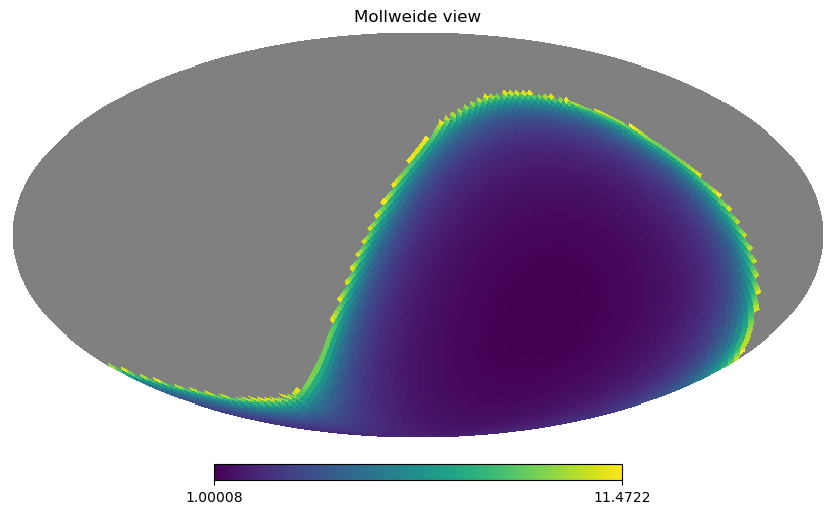

In [4]:
hp.mollview(conditions.airmass)

In [5]:
am_bf = AirmassDistBasisFunction()

In [6]:
am_bf(conditions)

array([0., 0., 0., ..., 0., 0., 0.])

In [7]:
am_bf.survey_features["n_airmass"].feature

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

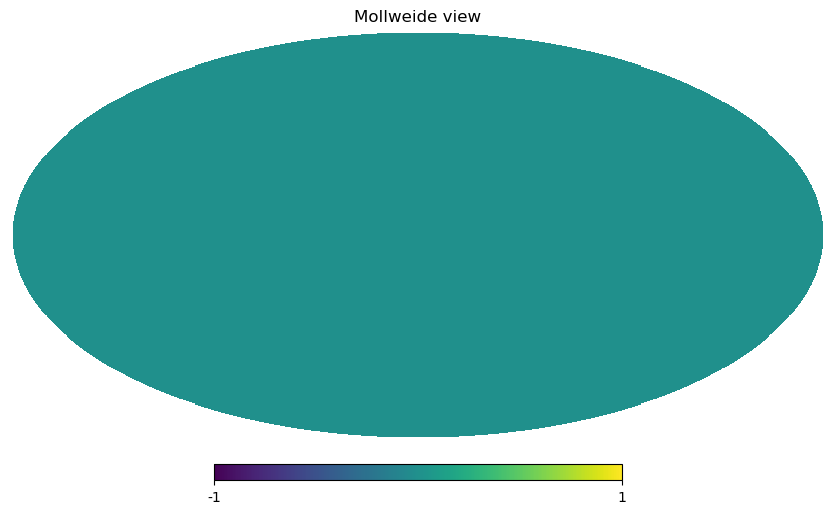

In [8]:
hp.mollview(am_bf(conditions))

In [9]:
observations = np.zeros(10, dtype=[("airmass", float), ("night", int)])
observations["airmass"] = 1.6

In [10]:
# Tell the basis function we've observed 10 times at some airmass
for obs in observations:
    am_bf.add_observation(obs)

In [11]:
am_bf.survey_features["n_airmass"].feature

array([ 0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0])

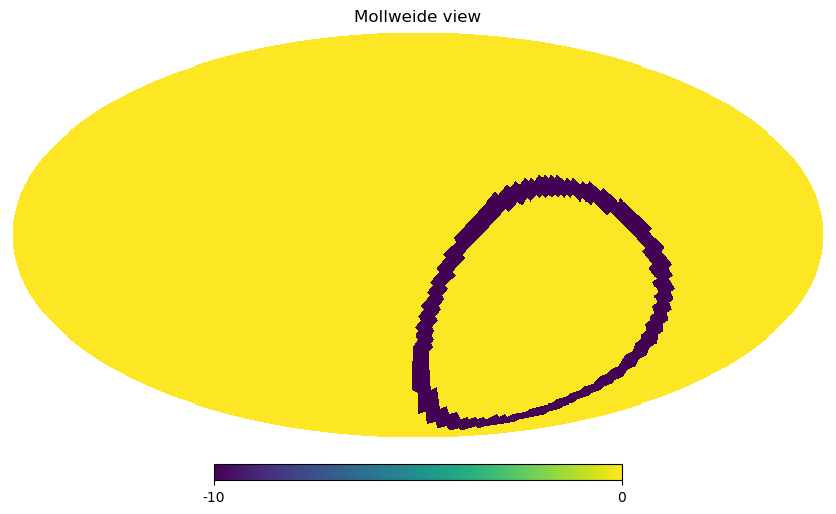

In [12]:
hp.mollview(am_bf(conditions))

In [13]:
# Now say we've observed 10 times at another airmass
observations["airmass"] = 2.8
for obs in observations:
    am_bf.add_observation(obs)

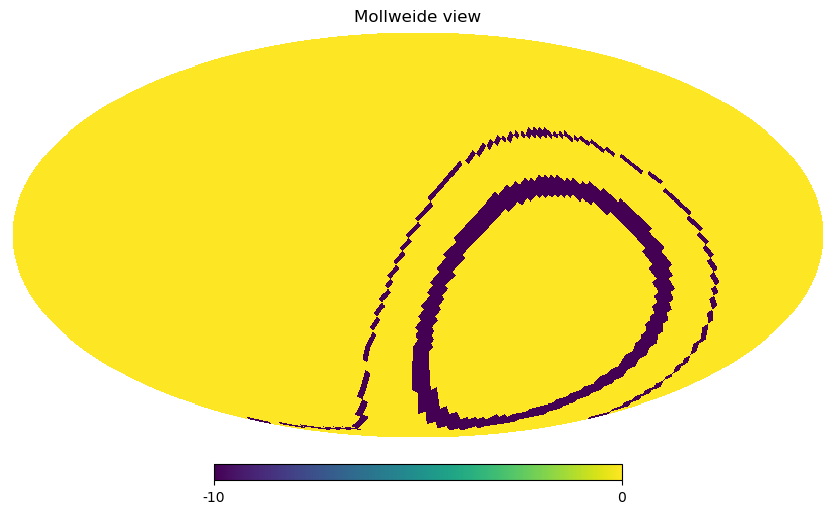

In [14]:
hp.mollview(am_bf(conditions))